In [1]:
# a bit of setup, as usual
import psycopg2 as ps
import psycopg2.extras as e

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

from itertools import product

# Visualization
First, let's connect to the Census dataset and plot some examples visualizations (views)

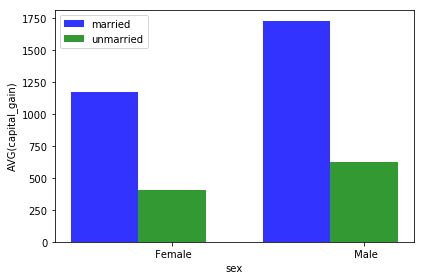

CPU times: user 321 ms, sys: 29.7 ms, total: 351 ms
Wall time: 791 ms


In [2]:
%%time

# connect to Census database
con = ps.connect("dbname='seedb' user='dthai' host='localhost' password=''")
cur = con.cursor()

# create view 
query = """create or replace view married as 
                   select * from census where marital_status in (' Married-AF-spouse', ' Married-civ-spouse', ' Married-spouse-absent',' Separated');
           create or replace view unmarried as 
                   select * from census where marital_status in (' Never-married', ' Widowed',' Divorced');"""
cur.execute(query)
con.commit()

# capital gain group-by sex for the target data (married)
query = "SELECT sex, avg(capital_gain) FROM married GROUP BY sex;"
cur.execute(query)
target_rows = cur.fetchall()

# capital gain group-by sex for the reference data (unmarried)
query = "SELECT sex, avg(capital_gain) FROM unmarried GROUP BY sex;"
cur.execute(query)
ref_rows = cur.fetchall()

# util function to plot the view 
def visualize(target_data, ref_data, view_tuple):
    n_groups = len(target_data)
    group_by, measure, function = view_tuple

    means_target = target_data.values()
    means_ref = ref_data.values()

    # create plot
    fig, ax = plt.subplots()
    index = np.arange(n_groups)
    bar_width = 0.35
    opacity = 0.8

    rects1 = plt.bar(index, means_target, bar_width,
                     alpha=opacity,
                     color='b',
                     label='married')

    rects2 = plt.bar(index + bar_width, means_ref, bar_width,
                     alpha=opacity,
                     color='g',
                     label='unmarried')

    plt.xlabel('{}'.format(group_by))
    plt.ylabel('{}({})'.format(function, measure))
    plt.xticks(index + bar_width, target_data.keys())
    plt.legend()

    plt.tight_layout()
    plt.show()

# visualize it!
view_tuple = ('sex', 'capital_gain', 'AVG')
visualize(dict(target_rows), dict(ref_rows), view_tuple)

# The phased-execution framework

We partition the Census dataset into 5 parts, corresponding to 5 phases. For each partitition, we create views for target (married) and reference (unmarried).

In [3]:
n_phases = 5

for i in range(n_phases):
    query = """create or replace view s{}_married as 
                   select * from split{} where marital_status in (' Married-AF-spouse', ' Married-civ-spouse', ' Married-spouse-absent',' Separated');
               create or replace view s{}_unmarried as 
                   select * from split{} where marital_status in (' Never-married', ' Widowed',' Divorced');""".format(i+1,i+1,i+1,i+1)
    cur.execute(query)
    con.commit()

## Sharing-based Optimizations

In [4]:
functions = ["avg", "sum", "min", "max", "count"]
attributes = ["workclass", "education", "occupation", "relationship", "race", "sex", "native_country", "economic_indicator"]
measurements = ["age", "fnlwgt", "hours_per_week", "capital_gain", "capital_loss"]

views = {k: v for k,v in enumerate(list(product(functions, measurements, attributes)))}
print('Total number of visualizations: {}.'.format(len(views)))

Total number of visualizations: 200.


In [5]:
%%time

def sharing_based_query(views, tables):
    # combine multiple aggregates and multiple group-by
    select_a_str = []
    select_m_str = []
    group_by_str = []
    for i, (f, m, a) in views.items():
        select_a_str.append('{}'.format(a))
        select_m_str.append('{}({}) as v{}'.format(f, m, i))
        group_by_str.append('({})'.format(a))

    select_a_str = ', '.join(set(select_a_str))
    select_m_str = ', '.join(select_m_str)
    group_by_str = ', '.join(set(group_by_str))

    data = []
    for table in tables:
        query = """select {}, {} from {} group by grouping sets ({});""".format(select_a_str, select_m_str, table, group_by_str)
        cur.execute(query)
        data.append(cur.fetchall())
    cols = [desc[0] for desc in cur.description]
    return data, cols

tables = ['married', 'unmarried']
data, cols = sharing_based_query(views, tables)

CPU times: user 11.7 ms, sys: 2.51 ms, total: 14.2 ms
Wall time: 1.65 s


In [6]:
def categorical_kl(tgt, ref):
    return -np.sum([qi * np.log(pi/qi) for qi, pi in zip(tgt, ref)])

def continuous_kl(tgt, ref):
    d = tgt - ref
    return 0.5 * np.dot(d.T, d)

# KL-Divergence(target, reference)
def kl_divergence(target_df, reference_df, function):
    tgt = target_df.reshape(-1)
    ref = reference_df.reshape(-1)
    
    if function == 'count':
        tgt_prob = tgt / np.sum(tgt)
        ref_prob = ref / np.sum(ref)
        return categorical_kl(tgt_prob, ref_prob)
    else:
        return continuous_kl(tgt, ref)

In [7]:
tgt_df = pd.DataFrame(data[0], columns=cols)
ref_df = pd.DataFrame(data[1], columns=cols)

view_scores = {}
for vid, (f, m, a) in views.items():
    tgt = tgt_df.loc[tgt_df[a].notnull(), [a, 'v{}'.format(vid)]]
    ref = ref_df.loc[ref_df[a].notnull(), [a, 'v{}'.format(vid)]]
    tmp = tgt.join(ref.set_index(a), on=a, how="inner", lsuffix='_tgt', rsuffix='_ref')
    
    tgt_val = tmp['v{}_tgt'.format(vid)].values
    ref_val = tmp['v{}_ref'.format(vid)].values
    score = kl_divergence(tgt_val, ref_val, f)
    view_scores[vid] = score

views_ranking = sorted(view_scores.items(), key=lambda x: x[1], reverse=True)

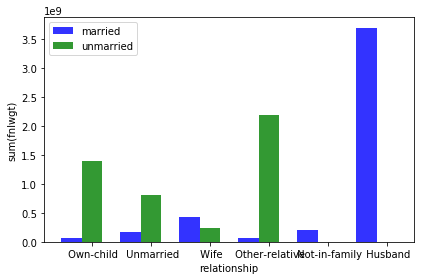

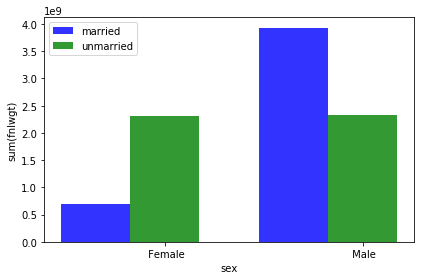

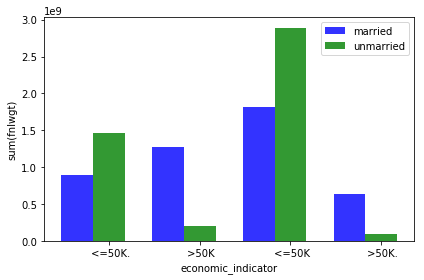

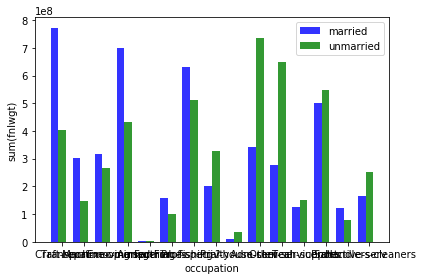

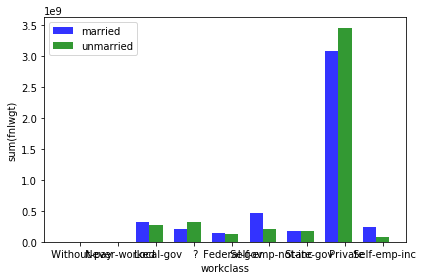

In [8]:
def top_k_views(ranking, k):
    for vid in ranking[:k]:
        f, m, a = views[vid]

        query = "SELECT {}, {}({}) FROM married GROUP BY {};".format(a, f, m, a)
        cur.execute(query)
        tgt_rows = cur.fetchall()

        query = "SELECT {}, {}({}) FROM unmarried GROUP BY {};".format(a, f, m, a)
        cur.execute(query)
        ref_rows = cur.fetchall()

        tgt_dict = dict(tgt_rows)
        ref_dict = dict(ref_rows)

        for k in tgt_dict.keys():
            if k not in ref_dict:
                ref_dict[k] = 0

        for k in ref_dict.keys():
            if k not in tgt_dict:
                tgt_dict[k] = 0

        visualize(tgt_dict, ref_dict, (a, m, f))

K = 5
top_k_views([r[0] for r in views_ranking], K)

## Pruning-based Optimizations

In this section we implement the two pruning schemes interval-based pruning and multi-armed bandit pruning.

### Interval-based pruning

0.831090117306
0.661413290751
0.491927244445
0.320572916736
Total number of pruned views: 0.


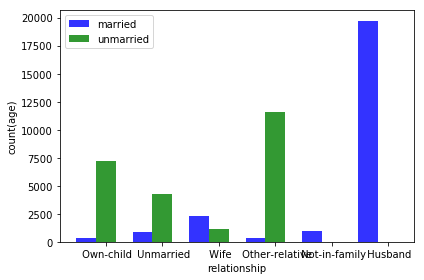

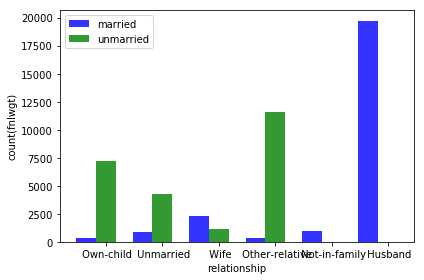

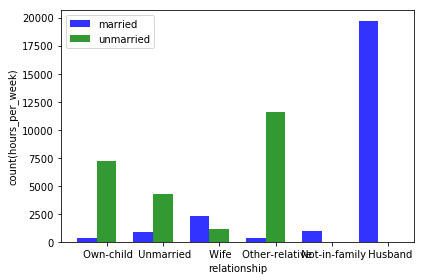

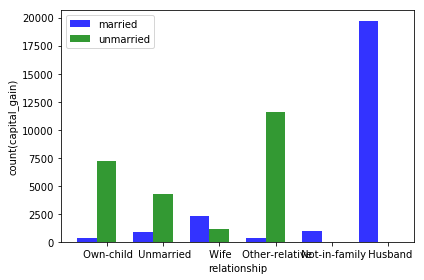

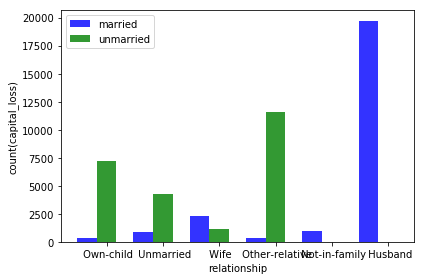

In [46]:
K = 5

view_scores = {k: [] for k, v in views.items()}
current_views = {k: v for k, v in views.items()}

delta = 0.05

for i in range(n_phases):
    tables = ['s{}_married'.format(i+1), 's{}_unmarried'.format(i+1)]
    data, cols = sharing_based_query(views, tables)
    
    tgt_df = pd.DataFrame(data[0], columns=cols)
    ref_df = pd.DataFrame(data[1], columns=cols)
    
    for vid, (f, m, a) in current_views.items():
        tgt = tgt_df.loc[tgt_df[a].notnull(), [a, 'v{}'.format(vid)]]
        ref = ref_df.loc[ref_df[a].notnull(), [a, 'v{}'.format(vid)]]
        tmp = tgt.join(ref.set_index(a), on=a, how="outer", lsuffix='_tgt', rsuffix='_ref').fillna(1e-5)

        tgt_val = tmp['v{}_tgt'.format(vid)].values
        ref_val = tmp['v{}_ref'.format(vid)].values
        score = kl_divergence(tgt_val, ref_val, distribution2type[f])
        view_scores[vid].append(score)
        
    if i > 0:
        m, N = i+1, n_phases
        eps = np.sqrt((0.5/m)*(1-((m-1)/N))*(2*np.log(np.log(m))+np.log((np.pi**2)/(3*delta))))
        print(eps)

        current_view_scores = [(k, v) for k, v in view_scores.items() if k in current_views]
        views_ranking = sorted(current_view_scores, key=lambda x: np.mean(x[1]), reverse=True)
        top_k_smallest_lower_bound = np.mean(views_ranking[K][1]) - eps

        for k, v in view_scores.items():
            if k in current_views and np.mean(v) + eps < top_k_smallest_lower_bound:
                del current_views[k]
            
print('Total number of pruned views: {}.'.format(len(views)-len(current_views)))
top_k_views([r[0] for r in views_ranking], K)

### Multi-armed bandit pruning

Total number of pruned views: 5.


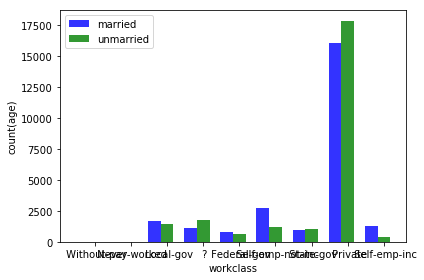

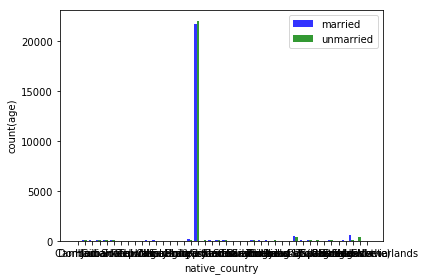

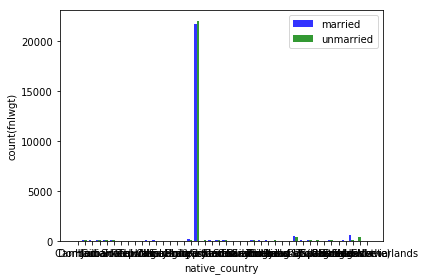

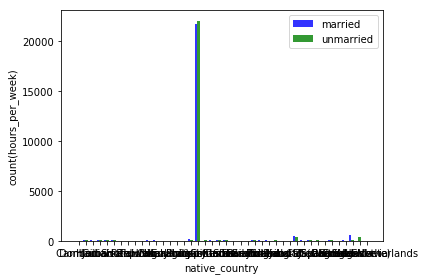

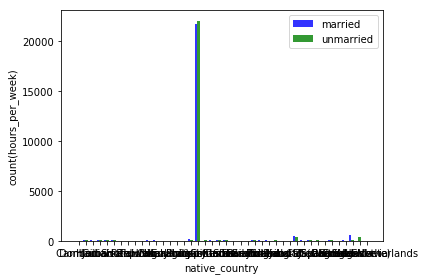

In [68]:
K = 5

view_scores = {k: [] for k, v in views.items()}
current_views = {k: v for k, v in views.items()}
accepted_views = []

for i in range(n_phases):
    tables = ['s{}_married'.format(i+1), 's{}_unmarried'.format(i+1)]
    data, cols = sharing_based_query(views, tables)
    
    tgt_df = pd.DataFrame(data[0], columns=cols)
    ref_df = pd.DataFrame(data[1], columns=cols)
    
    for vid, (f, m, a) in current_views.items():
        tgt = tgt_df.loc[tgt_df[a].notnull(), [a, 'v{}'.format(vid)]]
        ref = ref_df.loc[ref_df[a].notnull(), [a, 'v{}'.format(vid)]]
        tmp = tgt.join(ref.set_index(a), on=a, how="outer", lsuffix='_tgt', rsuffix='_ref').fillna(0)

        tgt_val = tmp['v{}_tgt'.format(vid)].values
        ref_val = tmp['v{}_ref'.format(vid)].values
        score = kl_divergence(tgt_val, ref_val, distribution2type[f])
        view_scores[vid].append(score)
    
    views_ranking = sorted(view_scores.items(), key=lambda x: np.mean(x[1]), reverse=True)
    
    delta_1 = np.mean(views_ranking[0][1]) - np.mean(views_ranking[K+1][1])
    delta_n = np.mean(views_ranking[K][1]) - np.mean(views_ranking[-1][1])
    
    if delta_1 > delta_n:
        accepted_views.append(views_ranking[0][0])
        del current_views[views_ranking[0][0]]
        del view_scores[views_ranking[0][0]]
    else:
        del current_views[views_ranking[-1][0]]
        del view_scores[views_ranking[-1][0]]

print('Total number of pruned views: {}.'.format(len(views)-len(current_views)))
top_k_views(accepted_views + [r[0] for r in views_ranking], K)